# TME3: Approches par modèles de substitution

In [225]:
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn import tree
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import svm
from sklearn.tree import _tree
import dice_ml
import pandas as pd
import matplotlib as plt

## Exercice 1 - Construction de règles contre-factuelles

Tree node count:  17
Node features:  [ 2 -2  3  2  3 -2 -2  3 -2  0 -2 -2  2  1 -2 -2 -2]
The point selected to test is:  [6.1 2.8 4.7 1.2]
Predicted class:  [1]
Decision path:  <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 5 stored elements and shape (1, 17)>
  Coords	Values
  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1


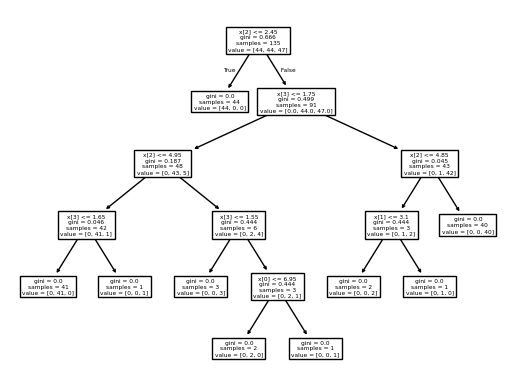

In [226]:
# 1. Choisir un ensemble de données et le séparer en une base d’apprentissage et une base de test.

data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=0.1, random_state=42)

# 2. Construire un arbre de décision avec la base d’apprentissage.
surrogate = DecisionTreeClassifier()
surrogate.fit(X_train, y_train)
arbre = surrogate.tree_

# 3. Choisir un exemple de la base de test comme exemple de référence x. Le classer 
# avec l’arbre de décision et afficher la règle activée pour son classement.
x = X_test[0]
tree.plot_tree(surrogate)

print("Tree node count: ", arbre.node_count)
print("Node features: ", arbre.feature)

print("The point selected to test is: ", x)
print("Predicted class: ", surrogate.predict([x]))
print("Decision path: ", surrogate.decision_path([x]))

In [227]:
# 4. Afficher toutes les règles contre-factuelles r′ 

leaf_id = surrogate.apply([x])
print("Leaf reached for x: ", leaf_id)
print("Class predicted for x: ", surrogate.predict([x]))

counterfactual_examples = []
counterfactual_paths = []

for ex in X_test:
    if (surrogate.predict([ex]) != surrogate.predict([x])):
        counterfactual_examples.append(ex)
        counterfactual_paths.append(surrogate.decision_path([ex]))

print("Number of counterfactual paths: ", len(counterfactual_paths))

for i in range(len(counterfactual_paths)):
    print("Counterfactual example ", i+1, ": ", counterfactual_examples[i])
    print("Counterfactual prediction ", i+1, ": ", surrogate.predict([counterfactual_examples[i]]))
    print("Counterfactual path ", i+1, ": ", counterfactual_paths[i])

Leaf reached for x:  [5]
Class predicted for x:  [1]
Number of counterfactual paths:  9
Counterfactual example  1 :  [5.7 3.8 1.7 0.3]
Counterfactual prediction  1 :  [0]
Counterfactual path  1 :  <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2 stored elements and shape (1, 17)>
  Coords	Values
  (0, 0)	1
  (0, 1)	1
Counterfactual example  2 :  [7.7 2.6 6.9 2.3]
Counterfactual prediction  2 :  [2]
Counterfactual path  2 :  <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 4 stored elements and shape (1, 17)>
  Coords	Values
  (0, 0)	1
  (0, 2)	1
  (0, 12)	1
  (0, 16)	1
Counterfactual example  3 :  [5.4 3.4 1.5 0.4]
Counterfactual prediction  3 :  [0]
Counterfactual path  3 :  <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2 stored elements and shape (1, 17)>
  Coords	Values
  (0, 0)	1
  (0, 1)	1
Counterfactual example  4 :  [6.9 3.1 5.1 2.3]
Counterfactual prediction  4 :  [2]
Counterfactual path  4 :  <Compressed Sparse Row sparse matrix of dtype '

In [228]:
# 4. (suite) ainsi que nr′ leur nombre de tests invalidés pour x.

# find the tree's learned rules
feature_names = data.feature_names

rules = []
rulepernode = [(0, [])]  

while rulepernode:
    node, current_rule = rulepernode.pop()

    # if it's an internal node
    if arbre.feature[node] != _tree.TREE_UNDEFINED:
        name = feature_names[arbre.feature[node]]
        threshold = arbre.threshold[node]

        # push children to rulepernode with updated rules
        left_rule = current_rule + [(name, "<=", threshold)]
        right_rule = current_rule + [(name, ">", threshold)]

        rulepernode.append((arbre.children_left[node], left_rule))
        rulepernode.append((arbre.children_right[node], right_rule))

    else:
        # it's a leaf -> save the rule and predicted class
        predicted_class = np.argmax(arbre.value[node])
        rules.append((node, current_rule, predicted_class))


# find each counterfactual path's number of invalidated rules for x

# create a mapping from leaf node id → index in rules list
leaf_to_rule_index = {leaf_node_id: idx for idx, (leaf_node_id, _, _) in enumerate(rules)}

# get leaf index for x
rule_x_leaf = surrogate.apply([x])[0]

# map leaf index to correct rules
_, rules_x_list, _ = rules[leaf_to_rule_index[rule_x_leaf]]


dict_counters = {}

for counter in counterfactual_examples:
    
    rule_counter = surrogate.apply([counter])[0]
    _, rules_counter_list, _ = rules[leaf_to_rule_index[rule_counter]]
    
    dict_counters[tuple(counter)] = []

    count = 0
    
    for r_x, r_c in zip(rules_x_list, rules_counter_list):
        if r_x != r_c:
            count += 1
            
    dict_counters[tuple(counter)] = (count, rules_counter_list)


# for each class different from x's, select the path with the smallest number 
# of invalidated tests for x

classes = surrogate.classes_
for i in range(len(classes)):
    if classes[i] == surrogate.predict([x]):
        counter_classes = np.delete(classes, i)

min_invalid = {}

for cl in counter_classes:
    for key in dict_counters:
        if surrogate.predict([key]) == cl:
            if (cl not in min_invalid) or (dict_counters[key][0] < dict_counters[min_invalid[cl][0]][0]):
                min_invalid[cl] = (key, dict_counters[key])


#format of min_invalid:
#    keys: all counterfactual classes
#    values: a tuple in the form of (counterfactual point, rule associated 
#            to that point prediction) with the counterfactual point corresponding
#            to the counterfactual to x with the minimum number of invalid rules
#            compared to x

print(min_invalid)

{np.int64(0): ((np.float64(5.7), np.float64(3.8), np.float64(1.7), np.float64(0.3)), (1, [('petal length (cm)', '<=', np.float64(2.449999988079071))])), np.int64(2): ((np.float64(7.7), np.float64(2.6), np.float64(6.9), np.float64(2.3)), (2, [('petal length (cm)', '>', np.float64(2.449999988079071)), ('petal width (cm)', '>', np.float64(1.75)), ('petal length (cm)', '>', np.float64(4.8500001430511475))]))}


 5. Proposer une explication pour la classification de x par l’arbre de décision.

In [229]:
# 6. Proposer une méthode de votre choix pour présenter à l’utilisateur l’explication fournie à la question précédente.

for key in min_invalid:
    print("x is in class ", surrogate.predict([x])[0], " and not in class ", key, "because:")

    rules_counter_list = min_invalid[key][1][1]

    for r_x, r_c in zip(rules_x_list, rules_counter_list):
        if r_x != r_c:
            print("- x has ", r_x[0], r_x[1], r_x[2], " and not ", r_c[0], r_c[1], r_c[2],)

x is in class  1  and not in class  0 because:
- x has  petal length (cm) > 2.449999988079071  and not  petal length (cm) <= 2.449999988079071
x is in class  1  and not in class  2 because:
- x has  petal width (cm) <= 1.75  and not  petal width (cm) > 1.75
- x has  petal length (cm) <= 4.950000047683716  and not  petal length (cm) > 4.8500001430511475


## Exercice 2 Génération de bases d’apprentissage et d’explications
## Explaining a SVC model output using a decision tree surrogate

In [230]:
clf = svm.SVC()
clf.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [231]:
# putting the process done in exercise 1 in a function that generates x, trains the surrogate, and prints the explanations of x

def explain(clf, x, data, X_test, y_test, npreds):
    
    # clf: binary classifier
    # x: the point to explain by the surrogate model
    # data: the scikitlearn dataset used
    # X_test
    # y_test
    # npreds: number of predictions from f to include in the training of the surrogate 
    #         must be smaller than len(X_test)

    # returns: min_valid
    # and prints the counterfactual explanations of the point x

    #format of min_invalid:
    #    keys: all counterfactual classes
    #    values: a tuple in the form of (counterfactual point, rule associated 
    #            to that point prediction) with the counterfactual point corresponding
    #            to the counterfactual to x with the minimum number of invalid rules
    #            compared to x

    predictions = clf.predict(X_test[0:npreds])
    
    surrogate = DecisionTreeClassifier()
    surrogate.fit(X_test, predictions)
    arbre = surrogate.tree_

    print("The point selected to test is: ", x)
    print("Predicted class: ", surrogate.predict([x]))
    print("Decision path: ", surrogate.decision_path([x]))

    # add parts 4 & 6

    counterfactual_examples = []
    counterfactual_paths = []
    
    for ex in X_test:
        if (surrogate.predict([ex]) != surrogate.predict([x])):
            counterfactual_examples.append(ex)
            counterfactual_paths.append(surrogate.decision_path([ex]))

    # find the tree's learned rules
    feature_names = data.feature_names
    
    rules = []
    rulepernode = [(0, [])]  
    
    while rulepernode:
        node, current_rule = rulepernode.pop()
    
        # if it's an internal node
        if arbre.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[arbre.feature[node]]
            threshold = arbre.threshold[node]
    
            # push children to rulepernode with updated rules
            left_rule = current_rule + [(name, "<=", threshold)]
            right_rule = current_rule + [(name, ">", threshold)]
    
            rulepernode.append((arbre.children_left[node], left_rule))
            rulepernode.append((arbre.children_right[node], right_rule))
    
        else:
            # it's a leaf -> save the rule and predicted class
            predicted_class = np.argmax(arbre.value[node])
            rules.append((node, current_rule, predicted_class))
    
    
    # find each counterfactual path's number of invalidated rules for x
    
    # create a mapping from leaf node id → index in rules list
    leaf_to_rule_index = {leaf_node_id: idx for idx, (leaf_node_id, _, _) in enumerate(rules)}
    
    # get leaf index for x
    rule_x_leaf = surrogate.apply([x])[0]
    
    # map leaf index to correct rules
    _, rules_x_list, _ = rules[leaf_to_rule_index[rule_x_leaf]]
    
    
    dict_counters = {}
    
    for counter in counterfactual_examples:
        
        rule_counter = surrogate.apply([counter])[0]
        _, rules_counter_list, _ = rules[leaf_to_rule_index[rule_counter]]
        
        dict_counters[tuple(counter)] = []
    
        count = 0
        
        for r_x, r_c in zip(rules_x_list, rules_counter_list):
            if r_x != r_c:
                count += 1
                
        dict_counters[tuple(counter)] = (count, rules_counter_list)
    
    
    # for each class different from x's, select the path with the smallest number 
    # of invalidated tests for x
    
    classes = surrogate.classes_
    for i in range(len(classes)):
        if classes[i] == surrogate.predict([x]):
            counter_classes = np.delete(classes, i)
    
    min_invalid = {}
    
    for cl in counter_classes:
        for key in dict_counters:
            if surrogate.predict([key]) == cl:
                if (cl not in min_invalid) or (dict_counters[key][0] < dict_counters[min_invalid[cl][0]][0]):
                    min_invalid[cl] = (key, dict_counters[key])

    class_names = data.target_names
    
    for key in min_invalid:
        print("x is in class ", class_names[surrogate.predict([x])[0]], " and not in class ", class_names[key], "because:")
    
        rules_counter_list = min_invalid[key][1][1]
    
        for r_x, r_c in zip(rules_x_list, rules_counter_list):
            if r_x != r_c:
                print("- x has ", r_x[0], r_x[1], r_x[2], " and not ", r_c[0], r_c[1], r_c[2],)

In [232]:
explain(clf, x, data, X_test, y_test, 100)

The point selected to test is:  [6.1 2.8 4.7 1.2]
Predicted class:  [1]
Decision path:  <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3 stored elements and shape (1, 5)>
  Coords	Values
  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
x is in class  versicolor  and not in class  setosa because:
- x has  petal length (cm) > 2.649999976158142  and not  petal length (cm) <= 2.649999976158142
x is in class  versicolor  and not in class  virginica because:
- x has  petal width (cm) <= 1.75  and not  petal width (cm) > 1.75


## Exercise 2, method 2: explaining a decision tree output using a DiCE surrogate

In [233]:
X, y = load_wine(return_X_y=True,as_frame=True)
# 1. séparer en base d'aprentissage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# 2. Construire un arbre de décision
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [234]:
# 3. exemple de reference
x = X_test.to_numpy()[0].reshape(1, -1)
y_pred = clf.predict(x)
path = clf.decision_path(x)
print(path)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 4 stored elements and shape (1, 13)>
  Coords	Values
  (0, 0)	1
  (0, 6)	1
  (0, 8)	1
  (0, 12)	1


/home/marilynch/mind/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/marilynch/mind/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [235]:
# 4. Afficher toutes les r`egles contre-factuelles r′ ainsi que nr′ leur nombre de tests invalid´es pour x.

def extract_rules(clf, feature_names):
    paths = []
    def recurse(node, path):
        if clf.tree_.feature[node] != -2:  # not a leaf
            name = feature_names[clf.tree_.feature[node]]
            threshold = clf.tree_.threshold[node]
            recurse(clf.tree_.children_left[node], path + [(name, "<=", threshold)])
            recurse(clf.tree_.children_right[node], path + [(name, ">", threshold)])
        else:
            paths.append(path)
    recurse(0, [])
    return paths

rules = extract_rules(clf, X.columns)

In [236]:
def count_invalid_tests(x, rule):
    invalid = 0
    for (name, op, thresh) in rule:
        val = x[0, X.columns.get_loc(name)]
        if op == "<=" and not (val <= thresh):
            invalid += 1
        if op == ">" and not (val > thresh):
            invalid += 1
    return invalid

for i, r in enumerate(rules):
    n_invalid = count_invalid_tests(x, r)
    print(f"Rule {i+1}: {r}")
    print(f"  -> invalid tests for x: {n_invalid}\n")

Rule 1: [('color_intensity', '<=', np.float64(3.819999933242798)), ('proline', '<=', np.float64(1002.5)), ('ash', '<=', np.float64(3.0700000524520874))]
  -> invalid tests for x: 1

Rule 2: [('color_intensity', '<=', np.float64(3.819999933242798)), ('proline', '<=', np.float64(1002.5)), ('ash', '>', np.float64(3.0700000524520874))]
  -> invalid tests for x: 2

Rule 3: [('color_intensity', '<=', np.float64(3.819999933242798)), ('proline', '>', np.float64(1002.5))]
  -> invalid tests for x: 2

Rule 4: [('color_intensity', '>', np.float64(3.819999933242798)), ('flavanoids', '<=', np.float64(1.399999976158142))]
  -> invalid tests for x: 1

Rule 5: [('color_intensity', '>', np.float64(3.819999933242798)), ('flavanoids', '>', np.float64(1.399999976158142)), ('proline', '<=', np.float64(724.5)), ('alcohol', '<=', np.float64(13.174999713897705))]
  -> invalid tests for x: 2

Rule 6: [('color_intensity', '>', np.float64(3.819999933242798)), ('flavanoids', '>', np.float64(1.399999976158142)), (

In [237]:
df_train = X_train.copy()
df_train["target"] = y_train.values

continuous_features = list(X.columns)
outcome_name = "target"

data_dice = dice_ml.Data(
    dataframe=df_train,
    continuous_features=continuous_features,
    outcome_name=outcome_name
)
model_dice = dice_ml.Model(model=clf, backend='sklearn')

explainer = dice_ml.Dice(data_dice, model_dice, method='random')

pred = int(clf.predict(x)[0])

target_class = (pred + 1) % len(clf.classes_)

x = X_test.iloc[[0]]

/home/marilynch/mind/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [238]:
generated_cf = explainer.generate_counterfactuals(
    x,
    total_CFs=5,
    desired_class=target_class,
    posthoc_sparsity_param=0.1
)

generated_cf.visualize_as_dataframe()

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.18it/s]

Query instance (original outcome : 0)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.64,3.1,2.56,15.2,116.0,2.7,3.03,0.17,1.66,5.1,0.96,3.36,845.0,0



Diverse Counterfactual set (new outcome: 1)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.64,3.1,1.59,15.2,116.0,2.7,3.03,0.17,1.66,2.0,0.96,3.36,845.0,1
1,13.64,3.1,2.56,15.2,116.0,2.7,3.03,0.17,1.66,2.7,0.96,3.36,845.0,1
2,13.64,3.1,2.56,15.2,116.0,2.7,3.03,0.17,1.66,2.1,0.96,3.36,845.0,1
3,13.64,3.1,2.56,15.2,116.0,2.7,3.03,0.17,1.66,2.5,1.11,3.36,845.0,1
4,11.50,3.1,2.56,15.2,116.0,2.7,3.03,0.17,1.66,2.4,0.96,3.36,845.0,1


In [239]:
cf_df = generated_cf.cf_examples_list[0].final_cfs_df[X.columns]
X_local = pd.concat([X_train, cf_df], ignore_index=True)
y_local = clf.predict(X_local)

g = DecisionTreeClassifier(max_depth=3, random_state=0)
g.fit(X_local, y_local)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [240]:
f_preds = clf.predict(X_local)
g_preds = g.predict(X_local)
fidelity = np.mean(f_preds == g_preds)
print(f"Local fidelity between f and g: {fidelity:.3f}")

Local fidelity between f and g: 0.994


In [241]:
x = X_test.to_numpy()[0].reshape(1, -1)

rules_surrogate = extract_rules(g, X.columns)

for i, r in enumerate(rules_surrogate):
    n_invalid = count_invalid_tests(x, r)
    print(f"Rule {i+1}: {r}")
    print(f"Invalid tests for x: {n_invalid}\n")

Rule 1: [('color_intensity', '<=', np.float64(3.819999933242798)), ('proline', '<=', np.float64(1002.5)), ('ash', '<=', np.float64(3.0700000524520874))]
Invalid tests for x: 1

Rule 2: [('color_intensity', '<=', np.float64(3.819999933242798)), ('proline', '<=', np.float64(1002.5)), ('ash', '>', np.float64(3.0700000524520874))]
Invalid tests for x: 2

Rule 3: [('color_intensity', '<=', np.float64(3.819999933242798)), ('proline', '>', np.float64(1002.5))]
Invalid tests for x: 2

Rule 4: [('color_intensity', '>', np.float64(3.819999933242798)), ('flavanoids', '<=', np.float64(1.399999976158142))]
Invalid tests for x: 1

Rule 5: [('color_intensity', '>', np.float64(3.819999933242798)), ('flavanoids', '>', np.float64(1.399999976158142)), ('proline', '<=', np.float64(724.5))]
Invalid tests for x: 1

Rule 6: [('color_intensity', '>', np.float64(3.819999933242798)), ('flavanoids', '>', np.float64(1.399999976158142)), ('proline', '>', np.float64(724.5))]
Invalid tests for x: 0



## Exercice 3 Expérimentations, Breast cancer dataset using a decision tree surrogate

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


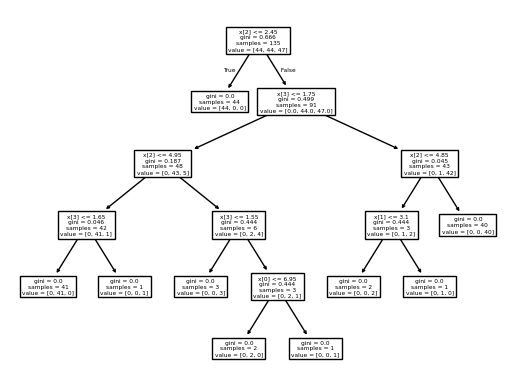

In [242]:
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=0.1, random_state=42)

# 3. Choisir un exemple de la base de test comme exemple de référence x. Le classer 
# avec l’arbre de décision et afficher la règle activée pour son classement.
x = X_test[0]
tree.plot_tree(surrogate)

clf = svm.SVC()
clf.fit(X_train, y_train)

In [243]:
explain(clf, x, data, X_test, y_test, 1000)

The point selected to test is:  [1.247e+01 1.860e+01 8.109e+01 4.819e+02 9.965e-02 1.058e-01 8.005e-02
 3.821e-02 1.925e-01 6.373e-02 3.961e-01 1.044e+00 2.497e+00 3.029e+01
 6.953e-03 1.911e-02 2.701e-02 1.037e-02 1.782e-02 3.586e-03 1.497e+01
 2.464e+01 9.605e+01 6.779e+02 1.426e-01 2.378e-01 2.671e-01 1.015e-01
 3.014e-01 8.750e-02]
Predicted class:  [1]
Decision path:  <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2 stored elements and shape (1, 3)>
  Coords	Values
  (0, 0)	1
  (0, 1)	1
x is in class  benign  and not in class  malignant because:
- x has  mean area <= 703.3999938964844  and not  mean area > 703.3999938964844
